In [12]:
import os,sys
ROOT_DIR = os.path.abspath("../../")
DATA_DIR = '/Users/csea/tensorflow_datasets/downloads/extracted'
sys.path.append(ROOT_DIR)  # To find local version of the library
LABELS_DIR = os.path.join(ROOT_DIR, 'data/interim')


import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image
from src.data import helper
import matplotlib.pyplot as plt
import skimage
from IPython.display import display
import re
from itertools import chain

In [3]:
from models.maskrcnn.mrcnn import visualize
from models.maskrcnn.mrcnn import model
# from models.maskrcnn.mrcnn import log
from models.maskrcnn.mrcnn import config
from models.maskrcnn.mrcnn.config import Config
from models.maskrcnn.mrcnn import model as modellib, utils

In [10]:
train = pd.read_csv(LABELS_DIR+'/train.csv')
test = pd.read_csv(LABELS_DIR+'/test.csv')
validation = pd.read_csv(LABELS_DIR+'/validation.csv')

train.head()

,image_id,filename,mask_name
0,tubingen_000067_000019,tubingen/tubingen_000067_000019_leftImg8bit.png,tubingen/tubingen_000067_000019_gtFine_color.png
1,jena_000090_000019,jena/jena_000090_000019_leftImg8bit.png,jena/jena_000090_000019_gtFine_color.png
2,zurich_000100_000019,zurich/zurich_000100_000019_leftImg8bit.png,zurich/zurich_000100_000019_gtFine_color.png
3,bremen_000273_000019,bremen/bremen_000273_000019_leftImg8bit.png,bremen/bremen_000273_000019_gtFine_color.png
4,strasbourg_000001_041215,strasbourg/strasbourg_000001_041215_leftImg8bi...,strasbourg/strasbourg_000001_041215_gtFine_col...


In [35]:
# def getPath(image_id, im_type: str='train',mask: bool=False, data_dir = DATA_DIR):
#     '''returns x,y paths for given image id
#     '''
#     assert im_type in ('train','test','validation','val')

#     parentFolder = re.findall('([a-z]{2,})',image_id)[0]
#     x = os.path.join(DATA_DIR,f'ZIP.leftImg8bit_trainvaltest.zip/leftImg8bit/{im_type}/{parentFolder}/{image_id}_leftImg8bit.png')
#     y = os.path.join(DATA_DIR, f'ZIP.gtFine_trainvaltest.zip/gtFine/{im_type}/{parentFolder}/{image_id}_gtFine_color.png')
#     return x,y

# def showSample(path):
#     img = Image.open(path)
#     display(img)

In [16]:
# # labels of interest
# labels = {
#     8: 'sidewalk',
#     12: 'wall',
#     17: 'pole',
#     18:  'polegroup',
#     20: 'trafic sign'
# }

In [17]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR,'models/maskrcnn/mask_rcnn_coco.h5')
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [175]:
def img_prep(img):
  pass
class CustomConfig(Config):
  NAME = 'sidewalks'
  GPU_COUNT = 1

  # 12GB GPU can typical handle 2 images (1024 x 1024)
  # ColabPro High Ram has roughly 27GB GPU
  IMAGES_PER_GPU = 4

  # Background + 1 sidewalk class 
  NUM_CLASSES = 2

  # Number of training steps per epoch
  STEPS_PER_EPOCH = 1000

  # Number of validation steps to runa tt eh end of 
  # every epoch,larger number improves better accuracy
  # but slows down training
  VALIDATION_STEPS = 50

  # ROIs belwo this threshold are skipped
  DETECTION_MIN_CONFIDENCE = .7   
  DETECTION_NMS_THRESHOLD = 0.3
  LEARNING_RATE =0.0005
  BACKBONE = 'resnet101'
  IMAGE_MAX_DIM = 512
  IMAGE_MIN_DIM = 512
  
class CustomDataset(utils.Dataset):
  def load_dataset(self,dataset_dir,subset):
    self.data_directory = dataset_dir
    self.add_class('cityscape',1,'sidewalk')
    
    # iterating to get the image ids
    if subset == 'validation':
      subset = 'val'
    subset = 'ZIP.leftImg8bit_trainvaltest.zip/leftImg8bit/'+subset
    dataset_dir = os.path.join(dataset_dir, subset)
    cities = [a for a in os.listdir(dataset_dir)]

    for city in cities:
      for image_id in os.listdir(os.path.join(dataset_dir,city)):
        temp_path = city+'/'+image_id
        self.add_image(source='cityscape',
                       image_id=image_id[:-4],
                       path = os.path.join(dataset_dir, temp_path))

      
  def load_mask(self,id):
    img_info = self.image_info[id]
    mask_dir = os.path.join(self.data_directory, 'ZIP.gtFine_trainvaltest.zip/gtFine/')
    
    city,id1,id2,_ = img_info['id'].split('_')
    subset = 'train'
    if city in os.listdir(os.path.join(mask_dir,'test')):
      subset = 'test'
    if city in os.listdir(os.path.join(mask_dir,'val')):
      subset='val'

    subset = subset +f'/{city}'
    mask_path = os.path.join(mask_dir, subset,'_'.join([city, id1,id2,'gtFine_color.png']))
    
    sidewalk_col = (244, 35,232)
    mask = np.all(skimage.io.imread(mask_path)[:,:,:3]==sidewalk_col, axis=-1)

    return mask, np.unique(mask).sum()

  def image_reference(self, id):
    pass

In [180]:
dataset = CustomDataset()
dataset.load_dataset('/Users/csea/Desktop/deep-learning-final-project-project-sidewalk/data/processed','train')

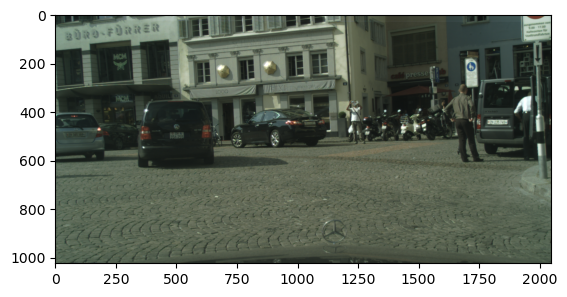

In [184]:
sample = dataset.load_image(0)
plt.imshow(sample)

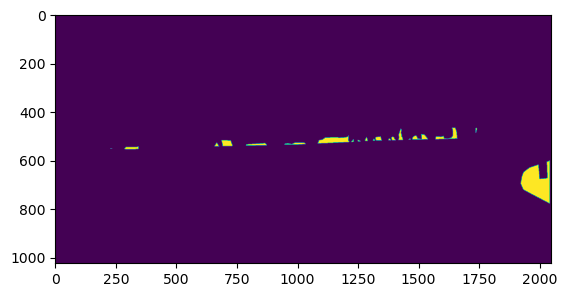

In [185]:
sample_mask, _ = dataset.load_mask(0)
plt.imshow(sample_mask)